# Cropping and resampling a grid

This notebook is part of a blog post on [Geophysics Labs].

Here I show how to interpolate a grid onto another grid, effectively cropping and resampling the first grid.

The initial grid is a 2D array obtained by color quantization of an RGB (three-band) image of a geological map. This previous step is described in [another notebook](02_Cropping_and_resampling_grid.ipynb).

The example shown here makes use of the Kevitsa dataset that was made freely available by the [Frank Arnott Award](https://www.frankarnottaward.com/Home.aspx).
<hr />
Let's start by loading some Python libraries. We need [SciPy](https://scipy.org/) for the interpolation functions and [rasterio](https://mapbox.github.io/rasterio/intro.html) for handling geographic information. Please refer to the index notebook for a tip about installing `rasterio`.

In [1]:
import numpy as np
from scipy import interpolate
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
% matplotlib inline

# Loading the data

First, let's reopen the indexed-colour image that was created at the previous step. It shows a portion of the geological map of the Kevitsa area in northern Finland. To display it properly, we also need to load the colour palette that associated with it.

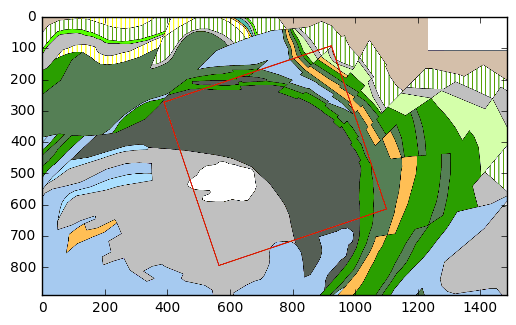

In [2]:
indexedImage = np.load(r'..\data\Kevitsa_geology_indexed.npy')
# load colormap
win256 = np.loadtxt(r'..\data\Windows_256_color_palette_RGB.csv',delimiter=',')
new_cm = mcolors.LinearSegmentedColormap.from_list('win256', win256/255)
# make plot
fig,ax = plt.subplots(figsize=(6,6))
ax.imshow(indexedImage,cmap=new_cm,norm=mcolors.NoNorm())

Next, we open the image file of the map that contains the geographic information about the position and extent of the map. The is important if we want to interpolate the image onto the grid of the 3D survey. This information is contained in a small text file (.pgw) that comes along with the PNG file.

In [3]:
inFile = r'..\data\Kevitsa_geology_noframe.png'
dataset = rasterio.open(inFile)

`Rasterio` has read the raster data but also the geographic information in the world (.pgw) file. Let's see what it contains:

In [4]:
nrows,ncols = dataset.shape
geotransform = dataset.get_transform()
cellsize = geotransform[1] 
# top-left corner of top-left pixel
ulx =      geotransform[0] 
uly =      geotransform[3]
# bottom-right corner of bottom-right pixel
lrx = ulx + geotransform[1] * ncols
lry = uly + geotransform[5] * nrows

# print the output
print('Raster Size: {:d} columns x {:d} rows x {:d} bands'.format(ncols, nrows, dataset.count))
print('Cell Size: {:.2f} m'.format(cellsize))
print('Upper-left corner:({:.2f},{:.2f})\nBottom-right corner:({:.2f},{:.2f})'.format(ulx,uly,lrx,lry))

Raster Size: 1485 columns x 890 rows x 4 bands
Cell Size: 5.08 m
Upper-left corner:(3494752.32,7514558.38)
Bottom-right corner:(3502295.11,7510037.79)


## Creating a set of grid coordinates

The next step is to create two arrays containing the X and Y positions of all the pixels of our image. Again, this is necessary for running the interpolation later on.

There are usually two methods to register 2D grids in space, depending on whether the coordinates correspond to the centres or to the corners of the pixels. GIS programs generally use the latter convention, as indeed the extent of a raster image starts from the very edge of the pixels. In contrast, geophysical software (OpendTect, Geosoft Oasis Montaj, etc.) tend to use the other method, registering the pixel centres because these are considered as any other data points. In this view, an image or a regular grid is simply a particulay case of a dataset consisting of observations that happened to be located at regular intervals.

A slightly different explanation of these two different methods of grid registration can be found on the [GMT website](http://gmt.soest.hawaii.edu/doc/latest/GMT_Docs.html#grid-registration-the-r-option). The principle is the same: in GMT jargon, gridline registration corresponds to corner-based coordinates, while the pixel registration makes use of centre-based coordinates. 

The conclusion of this short introduction to grid coordinates is that we have to use pixel-centre coordinates and that we have to calculate these from the pixel-corner coordinates provided by `rasterio`.    

In [5]:
xmin = ulx + cellsize/2.
ymin = lry + cellsize/2.
xmax = xmin + (ncols-1)*cellsize
ymax = ymin + (nrows-1)*cellsize

# 1-D arrays of coordinates (use linspace to avoid errors due to floating point rounding)
x = np.linspace(xmin,xmax,num=ncols,endpoint=True)
y = np.linspace(ymin,ymax,num=nrows,endpoint=True)
# 2-D arrays of coordinates
X,Y = np.meshgrid(x,y)

The X and Y arrays give the coordinates (X[i,j],Y[i,j]) of each pixel (i,j) in the image. However, we forgot a crucial difference between the orientation of the cartesian axes of our (projected) coordinate system and the arrangement of rows and columns in the array of the image. Basically, the origin (0,0) of array indices is in the top-left corner of the image, while the origin of the coordinate system is in the bottom-left corner. 

To correct for this difference, we simply need to flip the Y axis upside-down by adding the following:

In [6]:
Y = np.flipud(Y)

A plot of the X and Y arrays can help to ensure we have the expected set of X and Y coordinates.

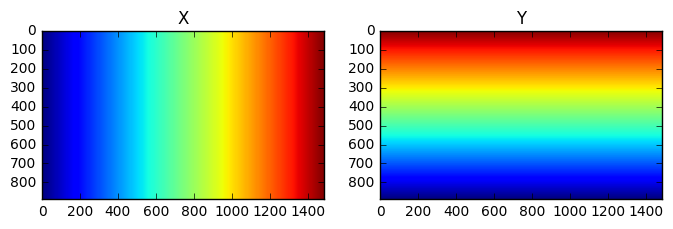

In [7]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,6))
ax1.imshow(X)
ax1.set_title('X')
ax2.imshow(Y)
ax2.set_title('Y')
plt.show()

# Performing the interpolation
## Creating interpolator

The interpolation in `SciPy` works by creating the interpolation function using the coordinates and the values of the data points. There are several types of interpolators available. For this type of data (image of a geological map), the best is to use a *nearest neighbour* interpolation, as we want to preserve the sharpness of the geological outlines. It is also vital for the quality of the result that indexed values in the image are not modified, since that would also modify their colour in an uncontrolled way.

In [9]:
interp = interpolate.NearestNDInterpolator(np.column_stack((X.flatten(),Y.flatten())),indexedImage.flatten())

## Creating target grid

The interpolation function will compute the intensities of the pixels at their new locations in the target grid. This new grid corresponds to the 3D seismic survey whose outline is shown in red on the map. 

Refering back to the [blog post](), we can fetch the definition of this grid from OpendTect. We are not limited to the boundaries of the 3D survey and we can add some padding in the form of additional rows and columns. The indexing is copied from the in-line and cross-line numbering in OpendTect.

In [10]:
# First let's define a grid of in-line and cross-line indices
pad = 50  # number of rows and columns to add on all sides
step = 1  # 
inline_limits = np.arange(1000-pad,1280+pad,step)
xline_limits = np.arange(1000-pad,1287+pad,step)
inline,xline = np.meshgrid(inline_limits,xline_limits,indexing='ij')
# indexing starts from bottom-left corner
inline = np.flipud(inline)

# Now we can compute the coordinates - these numbers come from the "advanced" panel in the coordinate settings in OpendTect
Xi = 3491336.248 - 3.19541219*inline + 9.4758042*xline
Yi = 7497848.4 + 9.47383513*inline + 3.19552448*xline

## Run the interpolation

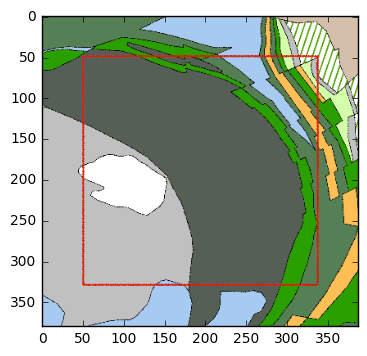

In [11]:
newImage = interp((Xi,Yi))
plt.imshow(newImage,cmap=new_cm)

The initial image has been rotated, cropped and resampled to match the position and extent of the 3D survey grid. It is now ready for export!

# Export to ASCII file

The final step is to create a text file containing the new interpolated image.

We can take advantage of the fact that the new grid has been defined using the same numbering as the traces of the 3D survey in OpendTect. So we don't need the coordinates, just the trace numbers.

The image will be imported in OpendTect as a 3D horizon. The colours will be treated as an attribute, so we need an extra Z column that will define the "geometry" of the horizon, a simple plane at depth = 0.

In [12]:
# Trace indices arranged in two vectors
IL_vector = inline.flatten()
XL_vector = xline.flatten()

# Data arranged in one single vector
values = newImage.flatten()

# Z column (zeros for importing in OpendTect)
Z_vector = np.zeros_like(IL_vector)

# Save to ASCII
outFile = r'..\data\Kevitsa_geology_indexed_ILXL.xyz'
np.savetxt(outFile,np.array((IL_vector,XL_vector,Z_vector,values)).T,fmt='%14.2f %14.2f %14.2f %.8g')
print('Done!')

Done!
